# Nettoyage des données

Le présent notebook regroupe le travail nécessaire au filtrage et nettoyage des données issue de l'initiative [Open Food Facts](https://world.openfoodfacts.org) dans le cadre de l'appel à projets de [l'Agence Santé Publique France](http://www.santepubliquefrance.fr/). 

Il a vocation à détailler le processus de nettoyage et de proposer, en fin de document, un script regroupant l'ensemble des fonction permettant de reproduire les opérations. 

## Contexte général 

L'Agence Santé Publique France cherche à lancer un appel à projets afin de trouver des idées innovantes en lien avec l'alimentation. 
Pour se faire, les candidats doivent se baser sur les données collectées par l'iniative Open Food Facts.


Celle-ci est portée par une association à but non lucratif. Cette dernière met à disposition, des consommateurs, une base de données de produits alimentaire.
Chaque entrée peut comporter:
- Le nom du produit
- Sa photo
- La photo de l'encart détaillant sa composition sur le packaging
- La photo de l'encart détaillant ses valeurs nutritionnelles sur le packaging
- Une analyse des ingrédients pouvant indiquer la présence ou non d'huile de palme dans la composition et le caractère végétalien ou non du produit
- La liste des additifs entrant dans la composition du produit
- Un indiquateur de groupe NOVA indiquant le niveau de transformation du produit allant de 1 (non ou peu transformé) à 4 (ultra transformé)
- Un indicateur de nutri-score indiquant la valeur nutritionnelle du produit allant de de A (aliments les plus sains) à E (aliments les moins sains)
- Les repères nutritionnels pour 100g
- La taille de la portion 
- Un tableau des informations nutritionnelles globales
- Un Eco-Score mesurant l'impact environnemental allant de A (faible impact)  à E (très fort impact)

Les enregistrements dans la base de données sont réalisées par des volontaires.


## Import des données

In [1]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import re
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
%matplotlib inline
dtypes = {
    "brand_owner":object,
    "generic_name":object,
    "ingredients_from_palm_oil_tags":object,
    "ingredients_that_may_be_from_palm_oil_tags":object,
    "origins":object,
    "origins_en":object,
    "origins_tags":object,
    "packaging_text":object,
    "traces":object,
    "traces_en":object,
    "traces_tags":object,
    "code":object,
    "abbreviated_product_name": object
    }
data = dd.read_csv("data.csv", sep = "\t", dtype=dtypes, low_memory=False).compute()

Affichons les cinq premières observations du dataset

In [2]:
display(data.head())
print(f"Dimensions du dataset : nombre d'observations {data.shape[0]} , nombre de variables {data.shape[1]}")

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,NaN,...,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dimensions du dataset : nombre d'observations 1672122 , nombre de variables 184


## Analyse des variables

A ce stade nous cherchons à déterminer les variables qui sont à la fois :
- perinentes dans le cadre de l'exploration
- discriminantes pour catégoriser les observations et dans un second temps
- qui ont un taux de complétion élevé. 

Concernant le dernier point, Il est acceptable de considérer des observations qui ont certaines variables non renseignées sous deux conditions:
- Que pour l'observation la proportion de variables retenues non renseignées soit faible
- Que globalement le taux de complétion global de chaque variable reste élevé

Dans ces deux cas il sera possible d'envisager des stratégies d'imputation pour compléter les valeurs manquantes.

Nous commençons par afficher l'ensemble des variables

In [3]:
list(data.columns)

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'abbreviated_product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'packaging_text',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'origins_en',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_t

De manière générale nous constatons que le nommage des variables est assez explicite. 

Il apparaît en première lecture que certaines ont un intérêt dans le cadre de la consitution de la base de données mais pas pour l'analyse des données : 

- code: identifiant du produit dans la base de données
- creator, created_t, created_datetime, last_modified_t, last_modified_datetime: variables relatives au volontaire qui a renseigné les données et les dates de créations / dernière modification de la fiche produit

D'autres variables semblent être présentées sous différentes formes. Dans ce cas de figure nous pouvons citer categories, labels, origins, countries par exemple. Dans le cadre du nettoyage nous ferons en sorte d'éviter la redondance d'informations. Il pourrait s'avérer nécessaire de supprimer certaines variables / représentations.  

Afin de faire un premier tri rapide des variable, nous créons une fonction de test du taux de complétion de chaque variable. Cette fonction sera utilisée à plusieurs reprises lors des différenntes étapes du nettoyage.

In [4]:
def test_completion(data):
    """
    Compute sorted completion rate and number of missing values for each variable of the argument in a descending order
    
    Args:
        data(dataset) : A dataset with variables
        
    Returns:
        A specific dataframe with completion rate for each variable. 
        Schema :
            Index(string): Variable names
            Taux de completion(float): completion rate
            Nombre de valeurs manquantes(int): Number of missing values
    """
    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de complétion", "Nombre de valeurs manquantes"]).sort_values(by="Taux de complétion", ascending=False)

Utilisons la fonction une première fois sur l'ensemble des données. 

In [5]:
pd.set_option('display.max_rows', 500)
test_completion(data)

,Taux de complétion,Nombre de valeurs manquantes
code,100.00,0
url,100.00,0
creator,100.00,4
created_t,100.00,0
created_datetime,100.00,0
last_modified_t,100.00,0
last_modified_datetime,100.00,0
states,100.00,0
states_tags,100.00,0
states_en,100.00,0


Nous observons que dès la 31e variable ayant le plus haut taux de complétion (sur 184), l'indicateur passe sous le seuil de 50%. A partir de là la baisse s'avère être très rapide. A noter que 48 variables ont un taux de complétion de 0%. 

Tout au long de la phase de nettoyage, notamment pour la suppresison des doublons, nous allons nous appuyer sur le produit "Nutella". Nous avons choisi ce produit car il est le second le plus représenté dans la base de donnés. Le premier étant la bouteille d'eau d'1L de Cristaline. Les eaux minérales étant un cas particulier, avec de nombreuses variables manquantes, nous avons préféré ne pas l'utiliser.

In [6]:
print(f"Nombre d'observations avec une variable product_name nutella ou Nutella {data[(data['product_name'] == 'Nutella') | (data['product_name'] == 'nutella')].shape[0]}")
print('20 premières observations avec un product_name "Nutella" ou "nutella":')
display(data[(data['product_name'] == 'Nutella') | (data['product_name'] == 'nutella')].head(20))

Nombre d'observations avec une variable product_name nutella ou Nutella 133
20 premières observations avec un product_name "Nutella" ou "nutella":


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
723,0000080135876,http://world-en.openfoodfacts.org/product/0000...,canieatthis-app,1479729948,2016-11-21T12:05:48Z,1479729948,2016-11-21T12:05:48Z,Nutella,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,0000080176800,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1548684719,2019-01-28T14:11:59Z,1548685066,2019-01-28T14:17:46Z,Nutella,NaN,NaN,...,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3967,0009800000753,http://world-en.openfoodfacts.org/product/0009...,openfoodfacts-contributors,1543864132,2018-12-03T19:08:52Z,1615337758,2021-03-10T00:55:58Z,Nutella,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22669,0015070422003,http://world-en.openfoodfacts.org/product/0015...,kiliweb,1613660979,2021-02-18T15:09:39Z,1613660980,2021-02-18T15:09:40Z,nutella,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8602,0062020000248,http://world-en.openfoodfacts.org/product/0062...,foodorigins,1447895880,2015-11-19T01:18:00Z,1598004772,2020-08-21T10:12:52Z,Nutella,NaN,NaN,...,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8603,0062020000316,http://world-en.openfoodfacts.org/product/0062...,kiliweb,1505925836,2017-09-20T16:43:56Z,1588176654,2020-04-29T16:10:54Z,Nutella,NaN,Tartinade aux noisettes (avec lait écrémé et c...,...,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8609,0062020000743,http://world-en.openfoodfacts.org/product/0062...,openfoodfacts-contributors,1397141520,2014-04-10T14:52:00Z,1575582517,2019-12-05T21:48:37Z,Nutella,NaN,NaN,...,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8610,0062020000842,http://world-en.openfoodfacts.org/product/0062...,openfoodfacts-contributors,1356872552,2012-12-30T13:02:32Z,1597838459,2020-08-19T12:00:59Z,Nutella,NaN,NaN,...,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8616,0062020003843,http://world-en.openfoodfacts.org/product/0062...,kiliweb,1521386576,2018-03-18T15:22:56Z,1588176693,2020-04-29T16:11:33Z,Nutella,NaN,NaN,...,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8633,0062020010285,http://world-en.openfoodfacts.org/product/0062...,kiliweb,1582497573,2020-02-23T22:39:33Z,1585885841,2020-04-03T03:50:41Z,Nutella,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous constatons plusieurs phénomènes:
- Un nombre important d'observations
- De nombreuses observation avec des variables non renseignées
- Sur les variables renseignées des valeurs similaires ou proches

## Filtrage sur le taux de complétion des varaibles

Afin de faire un premier tri nous allons filtrer les observations sur le fait que des valeurs sont présentes sur un ensemble de variables que nous pensons permettre de caractériser les produits:
- Product name: le nom du produit
- brands: une liste de marques associées au produit
- ppns_groups_1, ppns_groups_2 : groupes et sous-groupes d'aliments définis par l'Afssa (Agence Française de sécurité sanitaire des aliments) en 2001 et mis à jours par l'Anses en 2016. 
- nutriscore_grade et nova_groups : indicateur de nutriscore et de nova_group.

Les deux dernières variables ont été sélectionnées car elle sont construites à partir de plusieurs autres variables du jeu de données. Leur présence sous-tend que les variables nécessaires à leur construction sont égalements présentes.

In [7]:
data_not_na = data[data["product_name"].notna() 
                           & data["brands"].notna()
                           & data["pnns_groups_1"].notna() 
                           & data["pnns_groups_2"].notna()
                           & data["nutriscore_grade"].notna() 
                           & data["nova_group"].notna() 
                          ]

print(f"Nombre d'observations où les variables sélectionnées sont représentées: {data_not_na.shape[0]}")
print(f"Pourcentage des observations filtrées sur l'ensemble des données: {data_not_na.shape[0]/data.shape[0]*100:.2f}%")

Nombre d'observations où les variables sélectionnées sont représentées: 330526
Pourcentage des observations filtrées sur l'ensemble des données: 19.77%


Ce taux semble faible. Maintenant il représente tout de même un nombre de données conséquent permettant à la fois de mener analyse des données et l'entrainement d'un modèle de machine learning.
Afin de confirmer ce choix, observons à nouveaux les taux de complétion sur les données filtrées.

In [8]:
completions_not_na = test_completion(data_not_na)
completions_not_na

,Taux de complétion,Nombre de valeurs manquantes
code,100.00,0
brands,100.00,0
nutriscore_score,100.00,0
nutriscore_grade,100.00,0
nova_group,100.00,0
pnns_groups_1,100.00,0
pnns_groups_2,100.00,0
states,100.00,0
states_tags,100.00,0
states_en,100.00,0


Nous constatons globalement une augmentation sensible du taux de complétion sur les variables relatives aux qualités nutitrionnelles des observations. A titre d'exemple le taux de complétion de la varibale carbohydrates_100g (glucides pour 100 grammes) est passé de 78,93% à 99,59%. 

Zoomons en retenant que certaines colonnes:
- Les variables du filtre précédent
- nutrition-score-fr_100g: Nutritiion score ramenené à une quantité de 100 grammes. La donnée de par sa nature quatitative élargit de champ de possibilités d'application possibles.
- energy_100g, proteins_100g, sugars_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sodium_100g: variables de nutriments les plus représentées
- additives_n : nombre d'additifs dans le produits. Cette variable bien représentée offre également un angle supplémentaire à explorer 

A noter que la variable "salt" est également bien représentée. Maintenant son taux de complétion est égal à celui de la variable "sodium". Après étude il s'avère que le sodium est une des composante du sel. De ce fait il y a une corrélation très forte des deux variables. Il est donc inutil de conserver les deux. 

In [9]:
filtered_data = data_not_na.loc[:, ["product_name",
                                   "brands",
                                   "pnns_groups_1", 
                                   "pnns_groups_2",
                                   "additives_n",
                                   "energy_100g",
                                   "proteins_100g",
                                   "sugars_100g",
                                   "fat_100g",
                                   "saturated-fat_100g",
                                   "carbohydrates_100g",
                                   "sodium_100g",
                                   "nutrition-score-fr_100g",
                                   "nutriscore_grade",
                                   "nova_group"]
                               ]
test_filtered = test_completion(filtered_data)
display(test_filtered)
print(f"Nombre d'observations restantes {filtered_data.shape[0]}")
filteres_data = filtered_data.reset_index(drop=True)

,Taux de complétion,Nombre de valeurs manquantes
product_name,100.00,0
brands,100.00,0
pnns_groups_1,100.00,0
pnns_groups_2,100.00,0
nutrition-score-fr_100g,100.00,0
nutriscore_grade,100.00,0
nova_group,100.00,0
sodium_100g,99.73,897
additives_n,99.66,1125
energy_100g,99.64,1180


Nombre d'observations restantes 330526


## Suppression des valeurs aberrantes

D'après la nomenclature des données, les variables nutritionnelles mesurées en grammes (variables dont le nom se termine par _100g hormis energy_100g) ne peuvent pas avoir des valeurs supérrieures à 100. visualisons ces données avant de les supprimer.

In [10]:
outliers_100g = filtered_data[(filtered_data["proteins_100g"] > 100)
                              | (filtered_data["sugars_100g"] > 100)
                              | (filtered_data["fat_100g"] > 100)
                              | (filtered_data["saturated-fat_100g"] > 100)
                              | (filtered_data["carbohydrates_100g"] > 100)
                              | (filtered_data["sodium_100g"] > 100)] 

print(f"Nombre d'observations avec une ou plusieurs valeurs supérieures à 100 sur les variables nutritionnelles: {outliers_100g.shape[0]}")
print("20 premières valeurs aberrantes: ")
display(outliers_100g.head(20))

Nombre d'observations avec une ou plusieurs valeurs supérieures à 100 sur les variables nutritionnelles: 111
20 premières valeurs aberrantes: 


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
20054,Truvia,Truvia,unknown,unknown,1.0,0.0,0.0000,0.0000,0.0000,0.0000,133.0000,0.000000,0.0,b,4.0
19005,"Marie Sharp's, Orange Pulp Habanero Pepper Sau...",Melinda's Limited,Fat and sauces,Dressings and sauces,0.0,2008.0,14.0000,44.0000,0.0000,0.0000,90.0000,237.947200,19.0,e,3.0
23934,Tostitos Original Restaurant Style Tortilla Chips,"Frito-Lay Inc., Tostitos",Salty snacks,Appetizers,0.0,2090.0,25.5000,0.0000,89.3000,12.8000,242.0000,0.417000,17.0,d,3.0
24842,Nacho Cheese Flavored Tortilla Chips,Doritos,Salty snacks,Appetizers,8.0,5230.0,16.7000,8.3300,66.7000,8.3300,150.0000,1.750000,24.0,e,4.0
4771,Dried Apricots,Trader Joe's,Fruits and vegetables,Dried fruits,1.0,2620.0,6.2500,131.0000,0.0000,0.0000,156.0000,0.000000,9.0,c,1.0
3012,roland rolled fillets of anchovies,roland,Fish Meat Eggs,Fish and seafood,0.0,377.0,5.0000,0.0000,7.0000,0.0000,0.0000,995.680000,11.0,d,3.0
27754,"Roca Thins, Dark Chocolate With Toffee And Sea...",Brown & Haley,Sugary snacks,Chocolate products,1.0,5490.0,12.5000,87.5000,106.0000,62.5000,119.0000,0.405000,29.0,e,4.0
28260,Olive Oil,"Bertolli, Deoleo Usa Inc.",Fat and sauces,Fats,0.0,3350.0,0.0000,0.0000,622.0000,88.9000,0.0000,0.000000,5.0,c,2.0
7172,"Sargento, string cheese snacks",Sargento,Milk and dairy products,Cheese,0.0,1222.0,25.0000,0.0000,18.7500,12.5000,4.1700,719.666328,18.0,d,3.0
22265,QUESO MONTEREY JACK,JOSEPH FARMS,Milk and dairy products,Cheese,0.0,1610.0,0.0000,3.5700,32.1000,17.9000,0.0000,653.000000,24.0,e,3.0


Parmi ces observations nous en distinguons certaines qui sont remarquables:
- Celles ayant une valeur à zéro sur toutes les variables nutritionnelles à 0 sauf une à plus de 100 
- Celles ayant des varibales pnns_groups_1 et pnns_groups_2 avec une modalité "unknown"

Supprimons toutes les observations ayant une ou plusieurs valeurs de variables nutritionelles supérieures à 100.

In [11]:
filtered_data.drop(axis=0, index=outliers_100g.index, inplace=True)
print(f"nombre d'observations restantes {filtered_data.shape[0]}")

nombre d'observations restantes 329263


Pour identifier les valeurs aberrantes de la variable "energy_100g" nous utilisons un diagramme tige feuilles.

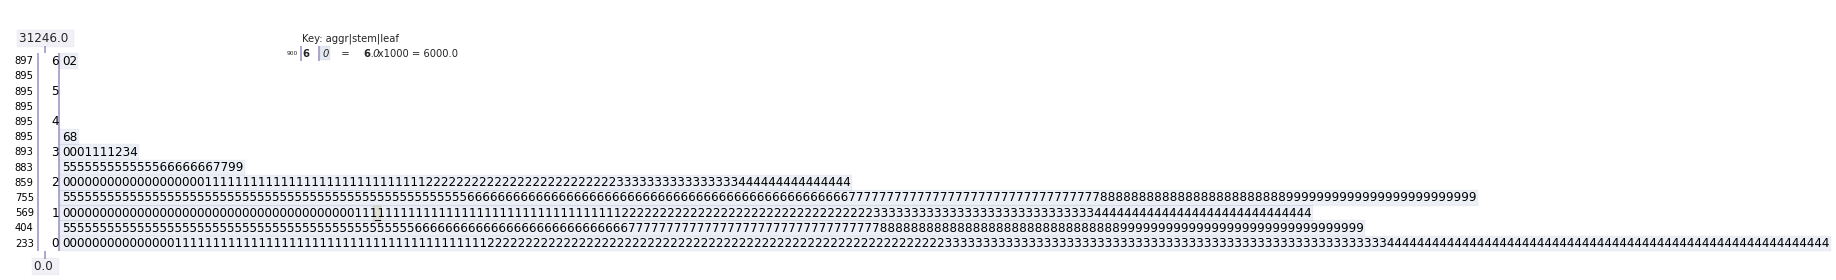

In [12]:
import stemgraphic
fig, ax = stemgraphic.stem_graphic(filtered_data["energy_100g"])

On peut en déduire que les valeurs sur la variable au dessus de 3900 sont aberrantes. Visualison le nombre des observations dans ce cas de figure et affichons en le premières.

In [13]:
energy_outliers = filtered_data[filtered_data["energy_100g"] > 3900]
print(f"Nombre d'observations ayant des valeurs aberrantes sur la variable energy_100g: {energy_outliers.shape[0]}")
print("20 premières valeurs aberrantes sur la variable energy_100g")
display(energy_outliers.head(20))

Nombre d'observations ayant des valeurs aberrantes sur la variable energy_100g: 252
20 premières valeurs aberrantes sur la variable energy_100g


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
2402,happy'box,haribo,Sugary snacks,Sweets,13.0,8400.0,5.400000,52.000000,0.500000,0.100000,80.000000,1.200000e-02,20.0,e,4.0
3690,Orange dark chocolate truffles,Lindt & Sprungli (Usa) Inc.,Sugary snacks,Sweets,1.0,11188.0,5.560000,36.110000,52.780000,36.110000,41.670000,3.000000e-02,26.0,e,4.0
4371,Cashews,Emerald,unknown,unknown,1.0,9996.0,17.140000,5.710000,45.710000,8.570000,28.570000,5.400000e-01,19.0,e,3.0
18669,Crown Peanut Butter Chunky,crown,Cereals and potatoes,Legumes,0.0,4770.0,22.000000,11.000000,47.000000,8.000000,26.000000,1.560000e-01,20.0,e,3.0
5937,Macaroni & cheese dinner,Kraft,unknown,unknown,3.0,6251.0,12.800000,8.500000,4.000000,2.000000,67.000000,3.256000e+00,22.0,e,4.0
19277,Milk chocolate rice cakes,By Sainsbury's,Cereals and potatoes,Cereals,1.0,8209.0,7.700000,32.400000,18.500000,11.000000,66.200000,7.200000e-02,27.0,e,4.0
24553,Funyuns,Funyuns,Salty snacks,Appetizers,2.0,4483.0,14.285714,3.571429,46.428571,7.142857,6.785714,2.142857e+00,25.0,e,4.0
29329,"Atkinson's, Crunchy Peanut Butter Bars",Atkinson Candy Company,unknown,unknown,0.0,6740.0,7.690000,53.850000,11.540000,0.000000,84.620000,1.540000e-04,20.0,e,4.0
16638,Raspberry Turnovers 4pk,Pepperidge Farms,Sugary snacks,Biscuits and cakes,2.0,4728.0,2.250000,14.610000,14.610000,7.870000,32.580000,2.580000e-04,19.0,e,4.0
21102,Chocolat noir,cémoi,Sugary snacks,Chocolate products,1.0,6540.0,12.500000,15.000000,47.500000,75.000000,35.000000,1.000000e-08,18.0,d,4.0


Sur ces observation certaines ont également des modalités "unknown" sur les variables pnns_groups_1 et pnns_groups_2. Nous reviendrons sur ce phénomène par la suite. Supprimons toutes les valeurs aberrantes sur la variable energy_100g.

In [14]:
filtered_data.drop(axis=0, index=energy_outliers.index, inplace=True)
filttered_data = filtered_data.reset_index(drop=True)
print(f"Nombre d'observations restantes: {filtered_data.shape[0]}")

Nombre d'observations restantes: 326310


## Supression des valeurs dupliquées

Commençons par observer les cinq premières lignes du dataframe filtré.

In [15]:
filtered_data.head()

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
68,BAguette bressan,Crousresto',Cereals and potatoes,Bread,3.0,669.0,9.5,0.60,2.2,0.5,25.20,0.1432,-4.0,a,4.0
276,Cranberries,Torn & Glasser,Fruits and vegetables,Fruits,0.0,1255.0,0.0,66.67,0.0,0.0,83.33,0.0000,3.0,c,3.0
328,Blanquette de Volaille et son Riz,Comme J’aime,Composite foods,One-dish meals,2.0,450.0,6.8,0.50,2.2,0.9,15.30,0.2800,0.0,b,4.0
331,Salade Cesar,Kirkland Signature,Fruits and vegetables,Vegetables,3.0,1210.0,22.0,0.00,12.0,7.0,23.00,0.8640,6.0,c,4.0
351,Entremets Crème Brulée,Comme j'aime,Milk and dairy products,Dairy desserts,4.0,1952.4,6.8,69.80,15.3,11.2,75.50,0.2000,2.0,b,4.0


Nous constatons que sur les variables qualitatives que les modalités contiennent des majuscules. Comme le montre la première ligne, certaines sont plus ou moins bien placée dans le termes des modalités. Le fait que les données soient renseignées librement par des volontaires peut sous-entendre que ces modalités ne sont pas normées. Dans ce cas une même modalité pourrait se retrouver avec plusieurs ortographes différfentes. Pour y remédier nous passons en minuscules toutes les modalités qualitatives nominales.

Voici le résultat:

In [16]:
for col in ['product_name', "brands", "pnns_groups_1", "pnns_groups_2", "nutriscore_grade"]:
    filtered_data[col] = filtered_data[col].str.lower()
filtered_data.head()

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
68,baguette bressan,crousresto',cereals and potatoes,bread,3.0,669.0,9.5,0.60,2.2,0.5,25.20,0.1432,-4.0,a,4.0
276,cranberries,torn & glasser,fruits and vegetables,fruits,0.0,1255.0,0.0,66.67,0.0,0.0,83.33,0.0000,3.0,c,3.0
328,blanquette de volaille et son riz,comme j’aime,composite foods,one-dish meals,2.0,450.0,6.8,0.50,2.2,0.9,15.30,0.2800,0.0,b,4.0
331,salade cesar,kirkland signature,fruits and vegetables,vegetables,3.0,1210.0,22.0,0.00,12.0,7.0,23.00,0.8640,6.0,c,4.0
351,entremets crème brulée,comme j'aime,milk and dairy products,dairy desserts,4.0,1952.4,6.8,69.80,15.3,11.2,75.50,0.2000,2.0,b,4.0


Observons a présent le nombre d'observsations qui sont intégrablement des doublons. Nous entendons les ensemble d'observations où chaque variable est égale. 

In [17]:
print(f"Nombre de doublons intégraux: {filtered_data[filtered_data.duplicated() == True].shape[0]}")

Nombre de doublons intégraux: 5455


Regardons le nombre de produits ayant la modalité nutella comme porduct_name après filtrage des colonnes et avant la suppresion des doublons intégraux.

In [18]:
display(filtered_data[filtered_data["product_name"] == "nutella"])
print(f"Nombre d'observation dont le product_name est nutella: {filtered_data[filtered_data['product_name'] == 'nutella'].shape[0]}")

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
724,nutella,ferrero,sugary snacks,sweets,1.0,2180.0,7.20,47.100000,27.0,9.5,60.7,0.223600,27.0,e,3.0
8602,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2226.0,6.30,57.600000,30.4,9.8,58.4,0.224000,27.0,e,4.0
8603,nutella,ferrero,sugary snacks,sweets,1.0,2201.0,0.05,58.000000,31.0,10.0,58.0,0.000000,25.0,e,4.0
8610,nutella,nutella,sugary snacks,sweets,1.0,2200.0,5.26,57.900000,31.6,10.5,57.9,0.053500,21.0,e,4.0
8616,nutella,ferrero,sugary snacks,sweets,1.0,2092.0,5.00,55.000000,30.0,10.0,55.0,0.000000,25.0,e,3.0
16183,nutella,ferrero,sugary snacks,sweets,1.0,2252.0,6.30,56.300000,30.9,10.6,57.5,0.042800,26.0,e,4.0
27433,nutella,ferrero,sugary snacks,sweets,1.0,2220.0,5.56,55.600000,33.3,11.1,55.6,0.056400,21.0,e,4.0
2697,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2278.0,6.00,56.800000,31.6,11.0,57.6,0.044000,26.0,e,4.0
2702,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2278.0,6.00,56.800000,31.6,11.0,57.6,0.045600,26.0,e,4.0
2703,nutella,ferrero,sugary snacks,sweets,1.0,2252.0,6.30,56.300000,30.9,10.6,57.5,0.042800,26.0,e,4.0


Nombre d'observation dont le product_name est nutella: 58


Nous supprimons les doublons intégraux et reclaculons le nombre d'observations restantes.

In [19]:
dedup_filtered_data = filtered_data.drop_duplicates()
dedup_filtered_data= dedup_filtered_data.reset_index(drop=True)
print(f"Nombre d'observations restantes après supression des doublons intégraux: {dedup_filtered_data.shape[0]}")

Nombre d'observations restantes après supression des doublons intégraux: 320855


Observons si cette suppression de doublons a eu un impact sur le nombre de produits avec Nutella comme modalité pour le product_name.

In [20]:
display(dedup_filtered_data[dedup_filtered_data["product_name"] == "nutella"])
print(f"Nombre d'observations dont le product_name est nutella: {dedup_filtered_data[dedup_filtered_data['product_name'] == 'nutella'].shape[0]}")

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
36,nutella,ferrero,sugary snacks,sweets,1.0,2180.0,7.20,47.100000,27.0,9.5,60.7,0.223600,27.0,e,3.0
47329,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2226.0,6.30,57.600000,30.4,9.8,58.4,0.224000,27.0,e,4.0
47330,nutella,ferrero,sugary snacks,sweets,1.0,2201.0,0.05,58.000000,31.0,10.0,58.0,0.000000,25.0,e,4.0
47331,nutella,nutella,sugary snacks,sweets,1.0,2200.0,5.26,57.900000,31.6,10.5,57.9,0.053500,21.0,e,4.0
47332,nutella,ferrero,sugary snacks,sweets,1.0,2092.0,5.00,55.000000,30.0,10.0,55.0,0.000000,25.0,e,3.0
82688,nutella,ferrero,sugary snacks,sweets,1.0,2252.0,6.30,56.300000,30.9,10.6,57.5,0.042800,26.0,e,4.0
103649,nutella,ferrero,sugary snacks,sweets,1.0,2220.0,5.56,55.600000,33.3,11.1,55.6,0.056400,21.0,e,4.0
137468,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2278.0,6.00,56.800000,31.6,11.0,57.6,0.044000,26.0,e,4.0
137471,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2278.0,6.00,56.800000,31.6,11.0,57.6,0.045600,26.0,e,4.0
137473,nutella,ferrero,sugary snacks,sweets,1.0,2255.0,6.30,56.300000,30.9,10.6,57.5,0.042800,26.0,e,4.0


Nombre d'observations dont le product_name est nutella: 40


On constate qu'après cette première suppresion, il reste toujours autant d'observations Nulettal avec des valeurs nutritionnelles très proches. De nombreuses observations ont des valeurs nutri-score-fr_100g et nova_group similaires entre elles. 
Essayons maintenant de dédoublonner à nouveau les observations sur la base de l'ensemble des variables suivantes: 
- product_name
- brands
- nutrition-scrore-fr_100g
- nova_group

In [21]:
full_dedup_data = dedup_filtered_data.drop_duplicates(subset = ["product_name", "brands","nutrition-score-fr_100g", "nova_group"])
full_dedup_data = full_dedup_data.reset_index(drop=True)
print(f"Nombre de doublons sur l'ensemble partiel de variables: {dedup_filtered_data[dedup_filtered_data.duplicated(subset = ['product_name', 'brands','nutrition-score-fr_100g', 'nova_group']) == True].shape[0]}")
print(f"Nombre d'observations restantes après le nouvelle déduplication {full_dedup_data.shape[0]}")
print("Premières ligne après déduplication:")
display(full_dedup_data.head())

Nombre de doublons sur l'ensemble partiel de variables: 7129
Nombre d'observations restantes après le nouvelle déduplication 313726
Premières ligne après déduplication:


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
0,baguette bressan,crousresto',cereals and potatoes,bread,3.0,669.0,9.5,0.60,2.2,0.5,25.20,0.1432,-4.0,a,4.0
1,cranberries,torn & glasser,fruits and vegetables,fruits,0.0,1255.0,0.0,66.67,0.0,0.0,83.33,0.0000,3.0,c,3.0
2,blanquette de volaille et son riz,comme j’aime,composite foods,one-dish meals,2.0,450.0,6.8,0.50,2.2,0.9,15.30,0.2800,0.0,b,4.0
3,salade cesar,kirkland signature,fruits and vegetables,vegetables,3.0,1210.0,22.0,0.00,12.0,7.0,23.00,0.8640,6.0,c,4.0
4,entremets crème brulée,comme j'aime,milk and dairy products,dairy desserts,4.0,1952.4,6.8,69.80,15.3,11.2,75.50,0.2000,2.0,b,4.0


Vérifions en visualisant à nouveau les observations dont le product_name est "Nutella".

In [22]:
display(full_dedup_data[full_dedup_data["product_name"] == "nutella"])
print(f"Nombre d'observations dont le product_name est 'Nutella': {full_dedup_data[full_dedup_data['product_name'] == 'nutella'].shape[0]}")

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
35,nutella,ferrero,sugary snacks,sweets,1.0,2180.0,7.20,47.1,27.0,9.5,60.7,0.223600,27.0,e,3.0
46210,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2226.0,6.30,57.6,30.4,9.8,58.4,0.224000,27.0,e,4.0
46211,nutella,ferrero,sugary snacks,sweets,1.0,2201.0,0.05,58.0,31.0,10.0,58.0,0.000000,25.0,e,4.0
46212,nutella,nutella,sugary snacks,sweets,1.0,2200.0,5.26,57.9,31.6,10.5,57.9,0.053500,21.0,e,4.0
46213,nutella,ferrero,sugary snacks,sweets,1.0,2092.0,5.00,55.0,30.0,10.0,55.0,0.000000,25.0,e,3.0
80809,nutella,ferrero,sugary snacks,sweets,1.0,2252.0,6.30,56.3,30.9,10.6,57.5,0.042800,26.0,e,4.0
101351,nutella,ferrero,sugary snacks,sweets,1.0,2220.0,5.56,55.6,33.3,11.1,55.6,0.056400,21.0,e,4.0
134547,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2278.0,6.00,56.8,31.6,11.0,57.6,0.044000,26.0,e,4.0
134552,nutella,"nutella, ferrero",sugary snacks,sweets,1.0,2278.0,6.00,56.8,31.6,11.0,57.6,0.045600,23.0,e,4.0
134554,nutella,"nutella,ferrero",sugary snacks,sweets,1.0,2273.0,6.00,56.7,31.6,10.9,57.3,0.037592,23.0,e,4.0


Nombre d'observations dont le product_name est 'Nutella': 19


Le nouveau dédoublonage a permis de passer de 41 à 15 observation ayant un product_name égal à "Nutella". On constate que certaines observations sont des doublons en ne prenant que les varaibles nutritionnelles comme critères de déduplications. Observonts les observation 136183 et 136184

In [23]:
full_dedup_data.loc[[136183,136184], :]

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
136183,l'instant apéro - rillettes de poulet - piment...,bordeau chesnel,salty snacks,salty and fatty products,0.0,1410.0,15.0,0.3,30.5,10.1,0.5,0.520,19.0,e,3.0
136184,rillettes de poulet,l'instant apero de bordeau chesnel,salty snacks,salty and fatty products,0.0,1397.0,14.9,1.3,29.3,9.4,2.5,0.428,17.0,d,3.0


Pour ces deux observations, seule la variable brans diffère. Celle-ci prend la forme d'une liste. Pour ces deux varables les termes des deux listes où les modalités sont inversées. Dans un cas "nutella, ferrero". Dans le second "ferrero, nutella". Nous reviendrons ultérieurement sur les variables qualitatives dont les modalités sont des listes.

Observons le nombre de doublons encore présents sur un critère de déduplication ne regroupants que le nom du produit et l'ensemble des variables des qualités nutritionnelles.

In [24]:
dedup_cols = ["product_name", "energy_100g", "proteins_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g"]
print(f" Nombre de doublons sur un critère de déducplitation comprenant le product name et les variables de valeurs nutritionnelles: {full_dedup_data[full_dedup_data.duplicated(subset = dedup_cols) == True].shape[0]}")

 Nombre de doublons sur un critère de déducplitation comprenant le product name et les variables de valeurs nutritionnelles: 10212


Le nombre conséquent des observation doublons sur le dernier critère nous amène à appliquer la déduplication.

In [25]:
full_dedup_data.drop_duplicates(subset = dedup_cols, inplace = True)
full_dedup_data= full_dedup_data.reset_index(drop=True)
print("Cinq premières observations après déduplication")
display(full_dedup_data.head())
print(f"Nombre d'observations restantes après déduplication: {full_dedup_data.shape[0]}")
print(f"Nombre d'observations avec un product_name égal à 'Nutella': {full_dedup_data[full_dedup_data['product_name'] == 'nutella'].shape[0]}")
print("Observation aevc un product_name égal à 'nutella' après déduplication")
display(full_dedup_data[full_dedup_data['product_name'] == 'nutella'])

Cinq premières observations après déduplication


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
0,baguette bressan,crousresto',cereals and potatoes,bread,3.0,669.0,9.5,0.60,2.2,0.5,25.20,0.1432,-4.0,a,4.0
1,cranberries,torn & glasser,fruits and vegetables,fruits,0.0,1255.0,0.0,66.67,0.0,0.0,83.33,0.0000,3.0,c,3.0
2,blanquette de volaille et son riz,comme j’aime,composite foods,one-dish meals,2.0,450.0,6.8,0.50,2.2,0.9,15.30,0.2800,0.0,b,4.0
3,salade cesar,kirkland signature,fruits and vegetables,vegetables,3.0,1210.0,22.0,0.00,12.0,7.0,23.00,0.8640,6.0,c,4.0
4,entremets crème brulée,comme j'aime,milk and dairy products,dairy desserts,4.0,1952.4,6.8,69.80,15.3,11.2,75.50,0.2000,2.0,b,4.0


Nombre d'observations restantes après déduplication: 303514
Nombre d'observations avec un product_name égal à 'Nutella': 15
Observation aevc un product_name égal à 'nutella' après déduplication


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
35,nutella,ferrero,sugary snacks,sweets,1.0,2180.0,7.20,47.1,27.0,9.5,60.7,0.223600,27.0,e,3.0
43855,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2226.0,6.30,57.6,30.4,9.8,58.4,0.224000,27.0,e,4.0
43856,nutella,ferrero,sugary snacks,sweets,1.0,2201.0,0.05,58.0,31.0,10.0,58.0,0.000000,25.0,e,4.0
43857,nutella,nutella,sugary snacks,sweets,1.0,2200.0,5.26,57.9,31.6,10.5,57.9,0.053500,21.0,e,4.0
43858,nutella,ferrero,sugary snacks,sweets,1.0,2092.0,5.00,55.0,30.0,10.0,55.0,0.000000,25.0,e,3.0
76291,nutella,ferrero,sugary snacks,sweets,1.0,2252.0,6.30,56.3,30.9,10.6,57.5,0.042800,26.0,e,4.0
95694,nutella,ferrero,sugary snacks,sweets,1.0,2220.0,5.56,55.6,33.3,11.1,55.6,0.056400,21.0,e,4.0
128090,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2278.0,6.00,56.8,31.6,11.0,57.6,0.044000,26.0,e,4.0
128096,nutella,"nutella,ferrero",sugary snacks,sweets,1.0,2273.0,6.00,56.7,31.6,10.9,57.3,0.037592,23.0,e,4.0
128125,nutella,"nutella,ferrero",sugary snacks,sweets,1.0,2218.0,6.80,55.0,31.0,10.0,56.0,0.012000,21.0,e,4.0


A ce stade il n'y a plus de doublons stricts. Maintenant nous observons des observations aux valeurs de variables nutritionnelles très proches. Plusieurs hypothèses sont envisageables:
- Variation de la recette du Netella dans le temps
- Variation de la recette du Nutella selon les zones géographiques où il est distribué
- Erreurs de saisie

Seule une connaissance métier fine pourrait nous permettre de pousser le nettoyage plus loin en utilisant ce type de méthode. Une solution envisageable, une fois échange avec un.e nutritioniste, pourrait être de remplacer toutes les observations ayant des valeurs pour les variables quantitatives très proches par une observation unique construite avec la moyenne ou la médiane de l'ensemble pour chaque variable.

## Nettoyage des variables pnns_groups_1 et pnns_groups_2

### Supression des valeurs de variables pnns_groups_1 et pnns_groups_2 "unknown"

Lors des différentes opérations de nettoyage nous avons constaté que même si le taux de complétion des variables pnns_groups_1 et ppns_gourps_2 ont un taux de complétion de 100%, certaines observations ont une valeur "unknown" pour cette variable. 

In [26]:
completion_pnns_1 = full_dedup_data["pnns_groups_1"].notna().shape[0] / full_dedup_data.shape[0] * 100
completion_pnns_2 = full_dedup_data["pnns_groups_2"].notna().shape[0] / full_dedup_data.shape[0] * 100
unknown_pnns_1 = full_dedup_data[full_dedup_data["pnns_groups_1"] == "unknown"].shape[0]
unknown_pnns_2 =  full_dedup_data[full_dedup_data["pnns_groups_2"] == "unknown"].shape[0]
print(f"Taux de completion de la variable 'pnns_groups_1': {completion_pnns_1}%")
print(f"Nombre d'observations où la variable 'pnns_groups_1' est 'unknown': {unknown_pnns_1}")
print(f"Taux de completion de la variable 'pnns_groups_2': {completion_pnns_2}%")
print(f"Nombre d'observations où la variable 'pnns_groups_2' est 'unknown': {unknown_pnns_2}")

Taux de completion de la variable 'pnns_groups_1': 100.0%
Nombre d'observations où la variable 'pnns_groups_1' est 'unknown': 46368
Taux de completion de la variable 'pnns_groups_2': 100.0%
Nombre d'observations où la variable 'pnns_groups_2' est 'unknown': 46368


Affin de systématiser la vérification de la présence de valeur "unknown" sur chaque variable nous créons une fonction et l'utilisons sur l'ensemble des données restantes:

In [27]:
def check_unknown(data):
    """
    Check if "unknown" value is present for some observations for each variable in the dataframe.
    
    Args:
        data(dataframe) : A dataframe to be checked
    Returns:
        Number of observations with an "unknow" value for each stream
    """
    
    unknown_dict = {}
    
    for col in data.columns:
        unknown_dict[col] = data[data[col] =="unknown"].shape[0]
    
    return pd.DataFrame.from_dict(data=unknown_dict, orient ="index", columns = ["Nombre d'observations unknown"]).sort_values(by="Nombre d'observations unknown", ascending=False)

check_unknown(full_dedup_data)

,Nombre d'observations unknown
pnns_groups_1,46368
pnns_groups_2,46368
product_name,0
brands,0
additives_n,0
energy_100g,0
proteins_100g,0
sugars_100g,0
fat_100g,0
saturated-fat_100g,0


Il n'y a bien que les variables pnns_groups_1 et pnns_groups_2 qui ont des observations avec des valeurs "unkwown". Nous décidons de supprimer ce observations.

In [28]:
idx_to_drop = list(full_dedup_data[full_dedup_data["pnns_groups_1"] == "unknown"].index)
cleaned_data = full_dedup_data.drop(labels = idx_to_drop)
cleaned_data = cleaned_data.reset_index(drop=True)
print(f"Nombre d'observations restantes: {cleaned_data.shape[0]}")
print("Taux de complétion après suppresion des observations")
display(test_completion(cleaned_data))
print("Cinq premières lignes des données après la nouvelle étape de nettoyage")
display(cleaned_data.head())

Nombre d'observations restantes: 257146
Taux de complétion après suppresion des observations


,Taux de complétion,Nombre de valeurs manquantes
product_name,100.00,0
brands,100.00,0
pnns_groups_1,100.00,0
pnns_groups_2,100.00,0
nutrition-score-fr_100g,100.00,0
nutriscore_grade,100.00,0
nova_group,100.00,0
sodium_100g,99.79,537
energy_100g,99.72,729
additives_n,99.71,739


Cinq premières lignes des données après la nouvelle étape de nettoyage


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
0,baguette bressan,crousresto',cereals and potatoes,bread,3.0,669.0,9.5,0.60,2.2,0.5,25.20,0.1432,-4.0,a,4.0
1,cranberries,torn & glasser,fruits and vegetables,fruits,0.0,1255.0,0.0,66.67,0.0,0.0,83.33,0.0000,3.0,c,3.0
2,blanquette de volaille et son riz,comme j’aime,composite foods,one-dish meals,2.0,450.0,6.8,0.50,2.2,0.9,15.30,0.2800,0.0,b,4.0
3,salade cesar,kirkland signature,fruits and vegetables,vegetables,3.0,1210.0,22.0,0.00,12.0,7.0,23.00,0.8640,6.0,c,4.0
4,entremets crème brulée,comme j'aime,milk and dairy products,dairy desserts,4.0,1952.4,6.8,69.80,15.3,11.2,75.50,0.2000,2.0,b,4.0


### Rectification des modalités aux orthographes proches

Sur ces les variables pnns_groups_1 et pnns_groups_2 nous constatons la possibilité que certains modalités aient des déclinaisons ortographiques. Regardons la liste des modalités représentées pour les deux variables:

In [29]:
print(f"Nombre de modalités pour la variable pnns_groups_1: {cleaned_data['pnns_groups_1'].nunique()}")
print("Liste des modalités de la variable pnns_groups_1")
display(cleaned_data["pnns_groups_1"].unique())
print("\n")
print(f"Nombre de modalités pour la variable pnns_groups_2: {cleaned_data['pnns_groups_2'].nunique()}")
print("Liste des modalités de la variable pnns_groups_2")
display(cleaned_data["pnns_groups_2"].unique())

Nombre de modalités pour la variable pnns_groups_1: 13
Liste des modalités de la variable pnns_groups_1


array(['cereals and potatoes', 'fruits and vegetables', 'composite foods',
       'milk and dairy products', 'sugary-snacks', 'fat and sauces',
       'salty snacks', 'beverages', 'sugary snacks', 'fish meat eggs',
       'fruits-and-vegetables', 'cereals-and-potatoes', 'salty-snacks'],
      dtype=object)



Nombre de modalités pour la variable pnns_groups_2: 38
Liste des modalités de la variable pnns_groups_2


array(['bread', 'fruits', 'one-dish meals', 'vegetables',
       'dairy desserts', 'pastries', 'dried fruits',
       'dressings and sauces', 'salty and fatty products',
       'sweetened beverages', 'pizza pies and quiche', 'sweets',
       'biscuits and cakes', 'fish and seafood', 'cheese', 'appetizers',
       'fats', 'chocolate products', 'unsweetened beverages',
       'sandwiches', 'legumes', 'cereals', 'processed meat', 'meat',
       'soups', 'milk and yogurt', 'nuts',
       'artificially sweetened beverages', 'fruit juices',
       'plant-based milk substitutes', 'ice cream', 'offals',
       'waters and flavored waters', 'teas and herbal teas and coffees',
       'eggs', 'potatoes', 'breakfast cereals', 'fruit nectars'],
      dtype=object)

Pour la variable pnns_groups_1 nous constatons 4 modalités avec une variation orthographique:
- "cereals and potatoes" avec "cereals-and-potatoes"
- "fruits and vegetables" avec "fruits-and-vegetables"
- "sugary snacks" avec "sugary-snacks"
- "salty snaks" eavec "salty-snaks"

Sur la variable pnns_groups_2 nous ne constatons pas de variable avec une variation orthographique. Nous procédons au remplacement des déclinaisons avec "-" par la version originale  et vérifions ensuite les modalités pnns_groups_1 nettoyées.

In [30]:
def clean_variable(row, clean_dict):
    """
    Clean values by maping with a dictionary. Keys are unapropriate values and values are expected value.
    Must be used with apply in a dataframe.
    
    Inputs:
        row(dataframe row): Row of a dataframe to check if has to be cleaned
        
        Clean_dict(dict): Dictionary used to clean values. 
        
    Returns:
        Cleaned values in tthetaframe.
    """
    
    for key, value in clean_dict.items():
        if row["pnns_groups_1"] == key:
            row["pnns_groups_1"] = value
            
    return row["pnns_groups_1"]

clean_dict = {"cereals-and-potatoes":"cereals and potatoes",
              "fruits-and-vegetables":"fruits and vegetables",
              "sugary-snacks":"sugary snacks",
              "salty-snacks":"salty snacks" }

cleaned_data["pnns_groups_1"] = cleaned_data.apply(clean_variable,axis=1,clean_dict=clean_dict)


print(f"Nombre de modalités pour la variable pnns_groups_1: {cleaned_data['pnns_groups_1'].nunique()}")
print("Liste des modalités de la variable pnns_groups_1")
display(cleaned_data["pnns_groups_1"].unique())

Nombre de modalités pour la variable pnns_groups_1: 9
Liste des modalités de la variable pnns_groups_1


array(['cereals and potatoes', 'fruits and vegetables', 'composite foods',
       'milk and dairy products', 'sugary snacks', 'fat and sauces',
       'salty snacks', 'beverages', 'fish meat eggs'], dtype=object)

## Suppression des observations où toutes les variables nutritionnelles sont absentes

Durant le travail de nettoyage nous avons également constaté des observations où toutes les variables nutritionnelles sont absentes. 

In [31]:
all_na = cleaned_data[cleaned_data["energy_100g"].isna()
                            & cleaned_data["proteins_100g"].isna()
                            & cleaned_data["sugars_100g"].isna()
                            & cleaned_data["fat_100g"].isna()
                            & cleaned_data["saturated-fat_100g"].isna()
                            & cleaned_data["carbohydrates_100g"].isna()
                            & cleaned_data["sodium_100g"].isna() 
                    ]
print(f"Nombre d'observations ayant toutes les variables nutritionnelles absentes: {all_na.shape[0]}")
print(f"Cinquante premières observations ayant toutes les variables nutritionnelles absentes")
display(all_na.head(50))

Nombre d'observations ayant toutes les variables nutritionnelles absentes: 494
Cinquante premières observations ayant toutes les variables nutritionnelles absentes


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
18593,agua,font natura,beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
25415,spring water,weis,beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
30193,gallon dasani,dasani,beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
33875,eau de source,amaro,beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
34606,nanton natural water artesian,nanton,beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
34683,bouteille d'eau nestlé pure life,nestlé,beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
37708,100% mountain spring water,arrowhead,beverages,waters and flavored waters,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
43546,"eau de source naturelle gazéifiée, 10 x 250 ml...","perrier, nestlé",beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
43927,crystal geyser natural alpine spring water,cg roxane,beverages,waters and flavored waters,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0
43928,natural spring water,crystal geyser,beverages,waters and flavored waters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a,1.0


Il apparaît qu'à une exception près tous ces produits sont des eaux minérales. En étudiant le phénomène nous avons pu voir sur le site de [60 millions de consommateurs](https://www.60millions-mag.com/2019/04/24/vos-aliments-preferes-sont-ils-sains-calculez-leur-nutri-score-12581) que ces produits se voient attribuer un nutri-score de A. Vérifions la proportion des eaux minérales sur les observations qui n'ont aucune valeur renseignées dans les variable de valeurs nutrinionnelles. 

In [32]:
waters_na = all_na[all_na['pnns_groups_2'] == 'waters and flavored waters'].shape[0]
others_na = all_na[all_na['pnns_groups_2'] != 'waters and flavored waters']
prop_waters_na = waters_na/cleaned_data[cleaned_data["pnns_groups_2"]=="waters and flavored waters"].shape[0]*100
print(f"Nombre d'observations ayant toutes les variables nutritionnelles absentes: {all_na.shape[0]}")
print(f"Nombre de ces observations ayant une valeur de variale pnns_groups_2 égale à 'waters and flavored waters': {all_na[all_na['pnns_groups_2'] == 'waters and flavored waters'].shape[0]} ")
print(f"Proportion du total précédent sur le nombre totale d'observations ayant une valeur de 'pnns_groups_2' égale à 'waters and flavored waters' {prop_waters_na:.2f}%")
print(f"Nombre d'observations ayant toutes les variables nutritionnelles absentes mais n'ayant pas une modalité de variable 'pnns_groups_2' égale à 'Waters and flavored waters': {others_na.shape[0]}")
print("Affichage des variables product_name, brands, pnns_groups_1, pnns_groups_2, nutriscore_grade, nova_group de cest dernières observations ")
display(others_na.loc[:,["product_name", "brands", "pnns_groups_1", "pnns_groups_2", "nutriscore_grade", "nova_group"]])
print(f"Nombre de modalités de pnns_groups_1 distinctes pour ces observations {others_na['pnns_groups_1'].nunique()}")
print(f"Nombre de modalités de pnns_groups_2 distinctes pour ces observations {others_na['pnns_groups_2'].nunique()}")

Nombre d'observations ayant toutes les variables nutritionnelles absentes: 494
Nombre de ces observations ayant une valeur de variale pnns_groups_2 égale à 'waters and flavored waters': 430 
Proportion du total précédent sur le nombre totale d'observations ayant une valeur de 'pnns_groups_2' égale à 'waters and flavored waters' 29.78%
Nombre d'observations ayant toutes les variables nutritionnelles absentes mais n'ayant pas une modalité de variable 'pnns_groups_2' égale à 'Waters and flavored waters': 64
Affichage des variables product_name, brands, pnns_groups_1, pnns_groups_2, nutriscore_grade, nova_group de cest dernières observations 


,product_name,brands,pnns_groups_1,pnns_groups_2,nutriscore_grade,nova_group
86669,instant noodles curry flavour,newgate,cereals and potatoes,cereals,c,4.0
87025,newgate instant instant noodles spicy prawn fl...,"newgate instant,newgate,lidl",composite foods,one-dish meals,c,4.0
87026,newgate instant instant noodles barbecue beef ...,"newgate instant,newgate,lidl",cereals and potatoes,cereals,c,4.0
96262,sirop bio de framboise,nature active bio,beverages,sweetened beverages,e,3.0
97240,knorr soupe tomates aux vermicelles 67g 4 port...,knorr,composite foods,one-dish meals,b,4.0
97274,knorr sauce poivre déshydratée 900g jusqu'à,knorr,fat and sauces,dressings and sauces,c,4.0
100949,lait écrémé en poudre,regilait,milk and dairy products,milk and yogurt,d,3.0
174122,quezac saveur citron/citron vert,quezac,beverages,sweetened beverages,a,4.0
184842,les copains gourmands - fernand le ferment pou...,"les copains gourmands,fernand le ferment",milk and dairy products,milk and yogurt,a,3.0
190425,heiße tasse tomate-mozzarella,erasco,composite foods,one-dish meals,c,4.0


Nombre de modalités de pnns_groups_1 distinctes pour ces observations 7
Nombre de modalités de pnns_groups_2 distinctes pour ces observations 10


De l'étude nous déduisons :
- La proportion d'eau minérales sans aucune variable nutritionnels renseignée sur l'ensemble des eaux inérales  est trop importante pour supprimer ces observations. 
- Les autres observations sont d'un nombre peut significatif et relativement dispersées au regard des variables pnns_groups_2. Nous pouvons donc les supprimer.

In [33]:
cleaned_data.drop(labels = others_na.index, inplace = True)
cleaned_data = cleaned_data.reset_index(drop=True)
print(f"Nombre d'observations restantes {cleaned_data.shape[0]}")
test_completion(cleaned_data)

Nombre d'observations restantes 257082


,Taux de complétion,Nombre de valeurs manquantes
product_name,100.00,0
brands,100.00,0
pnns_groups_1,100.00,0
pnns_groups_2,100.00,0
nutrition-score-fr_100g,100.00,0
nutriscore_grade,100.00,0
nova_group,100.00,0
sodium_100g,99.82,473
energy_100g,99.74,665
proteins_100g,99.73,683


À ce stade, dans le pire des cas, il reste 812 valeurs manquantes sur une variable. Nous arrêtons d'optimiser le taux de complétions. Les valeurs manquantes restantes pourront être imputés selon différetes méthodes que nous testerons. 

## Nettoyage des la variables avec des modalités sous forme de listes

### Nettotage de la variable brands

Nous avons pu voir avec l'exemple du Nutella que la varibale "brands" peut avoir une valeur qui peut être un nom de marque unique ou une liste de noms de marques.

In [34]:
cleaned_data[cleaned_data["product_name"] == "nutella"].head(2)

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
32,nutella,ferrero,sugary snacks,sweets,1.0,2180.0,7.2,47.1,27.0,9.5,60.7,0.2236,27.0,e,3.0
34003,nutella,"ferrero,nutella",sugary snacks,sweets,1.0,2226.0,6.3,57.6,30.4,9.8,58.4,0.2240,27.0,e,4.0


Observons dans quel mesure le phénomène est significatif.

In [35]:
cleaned_data["brands_tags"]=cleaned_data["brands"].apply(lambda x : x.split())
cleaned_data["brands_len"] = cleaned_data["brands_tags"].apply(lambda x : len(x))
print(f"Nombre d'observations où la variable brands n'a qu'une seule valeur: {cleaned_data[cleaned_data['brands_len']==1].shape[0]}")
print(f"Nombre d'observations où la variable brands est composée de plusieurs valeurs: {cleaned_data[cleaned_data['brands_len']!=1].shape[0]}")
print(f"Proportion d'observations où la variable brands est composée de plusieurs valeurs: {cleaned_data[cleaned_data['brands_len']!=1].shape[0]/cleaned_data.shape[0]*100:.2f}%")

Nombre d'observations où la variable brands n'a qu'une seule valeur: 124837
Nombre d'observations où la variable brands est composée de plusieurs valeurs: 132245
Proportion d'observations où la variable brands est composée de plusieurs valeurs: 51.44%


Ces résultats confirment la pertinance du nettoyage de la varibale brands.

Nous allons procéder un nettoyage de la colonne selon la règle suivante:
- Si pour une observation, la variable ne contient qu'un nom, la variable reste inchangée
- Si la varibale est une liste de noms: 
    - Dans le cas ou le premier nom est différents du "product_name" = la varibale prend le premier nom de la liste
    - Dans le cas contraire, il prend le second nom dans la liste
 Nous créons une function pour appliquer ce traitement.

In [36]:
def clean_list(row, col1, col2=None):
    """
    Transform a dataframe list values of a column to a single string.
    Function must be used in a pandas.DataFRame.apply
    
    Args:
        row(dataframe row): A row of a dataframe.
        
        col1(string): Name of the column to clean
        
        Col2(String): Name of a column to compare value with col1
        
    Returns:
        Cleaned dataframe
        
    Raises:
        "Cette fonction ne peut nettoyer que des colonnes avec des de variable quantitatives" if the column doesn't have an Object dtype
    
    """
    
    try:
        assert cleaned_data[col1].dtype == "O"
    except AssertionError:
        print("Cette fonction ne peut nettoyer que des colonnes avec des de variable quantitatives")
    
    pattern = re.compile("^.*,.*$")
    if re.fullmatch(pattern, row[col1]) is not None:
        words = row[col1].split(",")
        if col2 is not None:
            if str(words[0]) == row[col2] and str(words[1]) != "":
                return str(words[1])
            if str(words[0]) != "" :
                return str(words[0])
        if str(words[0]) != "":
            return str(words[0])
        else:
            return str(words[1])
    else:
        return row[col1]
    
cleaned_data["cleaned_brands"] = " "
cleaned_data["cleaned_brands"] = cleaned_data.apply(clean_list, axis=1, col1="brands", col2="product_name")
idx_first_nutella = list(cleaned_data[cleaned_data["product_name"] == "nutella"].index)
print("Vérification de la fonction sur les observations avec un product_name dont la valeur est 'Nutella'")
print("La colonne cleaned_brands correspond au résultat de la fonction")
cleaned_data.loc[idx_first_nutella, ["product_name","brands", "cleaned_brands"]]

Vérification de la fonction sur les observations avec un product_name dont la valeur est 'Nutella'
La colonne cleaned_brands correspond au résultat de la fonction


,product_name,brands,cleaned_brands
32,nutella,ferrero,ferrero
34003,nutella,"ferrero,nutella",ferrero
34004,nutella,ferrero,ferrero
34005,nutella,nutella,nutella
34006,nutella,ferrero,ferrero
58429,nutella,ferrero,ferrero
72016,nutella,ferrero,ferrero
97406,nutella,"ferrero,nutella",ferrero
97412,nutella,"nutella,ferrero",ferrero
97441,nutella,"nutella,ferrero",ferrero


Globalement la function a permis d'éviter de récupérer une valeur égale au product_name quand la variable brands est une liste. Dans le cas où la valeur de la variable brands n'est pas une liste, il reste des valeurs égales au product_name. Nous pouvons formuler l'hypotèse que le phénomène peut être dû au format collecte des données. Étudions les nombre d'observations où les valeurs des variables product_names et cleaned_brands sont égales

In [37]:
equals_prod_brands = cleaned_data[cleaned_data["cleaned_brands"] == cleaned_data["product_name"]]
cleaned_data["brands_len"] = cleaned_data["brands"].apply(lambda x : len(x))
print(f"Nombre d'observations où la variable brands n'a qu'une seule valeur: {cleaned_data[cleaned_data['brands_len']==1].shape[0]}")
print(f"Nombre d'observations où la variable brands est composée de plusieurs valeurs: {cleaned_data[cleaned_data['brands_len']!=1].shape[0]}")
print(f"Pourcentage d'observations la variable brands est composée de plusieurs valeurs: {cleaned_data[cleaned_data['brands_len']!=1].shape[0]/cleaned_data.shape[0]*100:.2f}%")
print(f"Nombre d'observation où les valeurs des variables product_name et cleaned_brands sont égales: {equals_prod_brands.shape[0]}")
print(f"Proortion d'observation où les valeurs des variables product_name et cleaned_brands sont égales {equals_prod_brands.shape[0]/cleaned_data.shape[0]*100:.2f}%")
print("Dix premierères observations où le phénomène est observé")
display(cleaned_data.loc[equals_prod_brands.index, :].head(10))

Nombre d'observations où la variable brands n'a qu'une seule valeur: 3312
Nombre d'observations où la variable brands est composée de plusieurs valeurs: 253770
Pourcentage d'observations la variable brands est composée de plusieurs valeurs: 98.71%
Nombre d'observation où les valeurs des variables product_name et cleaned_brands sont égales: 814
Proortion d'observation où les valeurs des variables product_name et cleaned_brands sont égales 0.32%
Dix premierères observations où le phénomène est observé


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group,brands_tags,brands_len,cleaned_brands
3516,tabasco,tabasco,fat and sauces,dressings and sauces,0.0,67.0,1.00,0.00,0.70000,0.20,1.600000,0.720000,6.0,c,3.0,[tabasco],7,tabasco
5028,7 up,7 up,beverages,sweetened beverages,4.0,79.0,0.00,5.00,0.00000,0.00,5.000000,0.000000,7.0,d,4.0,"[7, up]",4,7 up
6642,fiber one,fiber one,sugary snacks,biscuits and cakes,3.0,2001.0,4.35,0.00,21.73913,0.00,65.217391,0.217391,0.0,b,4.0,"[fiber, one]",9,fiber one
14866,earth balance,earth balance,fat and sauces,fats,2.0,293.0,0.00,0.00,8.00000,2.50,0.000000,0.080000,4.0,c,4.0,"[earth, balance]",13,earth balance
19241,m&m's,m&m's,sugary snacks,sweets,8.0,2033.0,2.86,65.71,25.71000,14.29,68.570000,0.100000,27.0,e,4.0,[m&m's],5,m&m's
26002,san pelegrino,san pelegrino,beverages,waters and flavored waters,NaN,0.0,0.00,0.00,0.00000,0.00,0.000000,0.001200,0.0,a,1.0,"[san, pelegrino]",13,san pelegrino
26128,almond breeze,almond breeze,beverages,plant-based milk substitutes,2.0,134.0,0.40,4.80,1.00000,0.08,5.200000,0.060000,1.0,b,4.0,"[almond, breeze]",13,almond breeze
27617,cinnamon toasters,cinnamon toasters,cereals and potatoes,cereals,5.0,1812.0,3.33,33.33,11.67000,1.67,80.000000,0.467000,15.0,d,4.0,"[cinnamon, toasters]",17,cinnamon toasters
28044,log cabin,log cabin,cereals and potatoes,cereals,5.0,1400.0,0.00,43.30,0.00000,0.00,88.300000,0.237000,15.0,d,4.0,"[log, cabin]",9,log cabin
28487,oreo,oreo,sugary snacks,biscuits and cakes,3.0,1969.0,4.41,39.71,19.12000,5.88,72.060000,0.403360,21.0,e,4.0,[oreo],4,oreo


Au vu de la très faible proportion d'obsrevations où la modalité de la variable product_name est égale à celle de cleaned_brands, nous choisissons de remplacer les valeurs de la variables brands par celles de cleaned_brands. Nous affichons une nouvelle fois les dix premières observations

In [38]:
cleaned_data["brands"] = cleaned_data["cleaned_brands"]
cleaned_data.drop(columns = ["cleaned_brands", "brands_len", "brands_tags"], axis=1, inplace=True)
cleaned_data.head(10)

,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group
0,baguette bressan,crousresto',cereals and potatoes,bread,3.0,669.0,9.50,0.60,2.2,0.5,25.20,0.1432,-4.0,a,4.0
1,cranberries,torn & glasser,fruits and vegetables,fruits,0.0,1255.0,0.00,66.67,0.0,0.0,83.33,0.0000,3.0,c,3.0
2,blanquette de volaille et son riz,comme j’aime,composite foods,one-dish meals,2.0,450.0,6.80,0.50,2.2,0.9,15.30,0.2800,0.0,b,4.0
3,salade cesar,kirkland signature,fruits and vegetables,vegetables,3.0,1210.0,22.00,0.00,12.0,7.0,23.00,0.8640,6.0,c,4.0
4,entremets crème brulée,comme j'aime,milk and dairy products,dairy desserts,4.0,1952.4,6.80,69.80,15.3,11.2,75.50,0.2000,2.0,b,4.0
5,chaussons tressés aux pommes,kirkland signature,sugary snacks,pastries,3.0,1090.0,3.33,24.70,10.7,2.0,38.70,0.2590,9.0,c,4.0
6,pommes séchées,kazidomi,fruits and vegetables,dried fruits,0.0,1222.0,2.00,51.00,0.5,0.1,65.00,0.0120,7.0,c,1.0
7,pesto à la roquette bio kazidomi,kazidomi,fat and sauces,dressings and sauces,0.0,2318.0,8.20,0.50,53.2,9.6,11.70,1.0800,23.0,e,3.0
8,crème d'artichaut bio kazidomi,kazidomi,salty snacks,salty and fatty products,1.0,1104.0,1.90,0.00,27.4,3.9,1.80,1.0800,11.0,d,3.0
9,root beer,a&w,beverages,sweetened beverages,3.0,213.0,0.00,0.00,0.0,0.0,14.00,0.4000,12.0,e,4.0


### Nettoyage de la variable product_name

Durant l'étude, la varibale product_name semble reproduire le même phénomène. Essayons d'appliquer le même traitement.

In [39]:
cleaned_data["product_name_tags"]=cleaned_data["product_name"].apply(lambda x : x.split())
cleaned_data["product_name_len"] = cleaned_data["product_name_tags"].apply(lambda x : len(x))
print(f"Nombre d'observations où la variable product_name n'a qu'une seule valeur avant traitement: {cleaned_data[cleaned_data['product_name_len']==1].shape[0]}")
print(f"Nombre d'observations où la variable product_name est composée de plusieurs valeurs avant traitement: {cleaned_data[cleaned_data['product_name_len']!=1].shape[0]}")
print(f"Pourcentage d'observations où la variable product_name est composée de plusieurs valeurs avant traitement: {cleaned_data[cleaned_data['product_name_len']!=1].shape[0]/cleaned_data.shape[0]*100:.2f}%")
cleaned_data["cleaned_product_name"] = ""
cleaned_data["cleaned_product_name"] = cleaned_data.apply(clean_list, axis=1, col1="product_name", col2="brands")
equals_prod_brands = cleaned_data[cleaned_data["cleaned_product_name"] == cleaned_data["brands"]]
print(f"Nombre d'observation où les valeurs des variables product_name et cleaned_brands sont égales: {equals_prod_brands.shape[0]}")
print(f"Proortion d'observation où les valeurs des variables product_name et cleaned_brands sont égales {equals_prod_brands.shape[0]/cleaned_data.shape[0]*100:.2f}%")
print("Dix premierères observations où le phénomène est observé")
display(cleaned_data.loc[equals_prod_brands.index, :].head(10))
cleaned_data["product_name"] = cleaned_data["cleaned_product_name"]
cleaned_data.drop(columns = ["cleaned_product_name", "product_name_tags", "product_name_len"], axis=1, inplace=True)
cleaned_data = cleaned_data.drop_duplicates(subset = ["product_name", "brands"])
cleaned_data = cleaned_data.reset_index(drop=True)

Nombre d'observations où la variable product_name n'a qu'une seule valeur avant traitement: 17570
Nombre d'observations où la variable product_name est composée de plusieurs valeurs avant traitement: 239512
Pourcentage d'observations où la variable product_name est composée de plusieurs valeurs avant traitement: 93.17%
Nombre d'observation où les valeurs des variables product_name et cleaned_brands sont égales: 815
Proortion d'observation où les valeurs des variables product_name et cleaned_brands sont égales 0.32%
Dix premierères observations où le phénomène est observé


,product_name,brands,pnns_groups_1,pnns_groups_2,additives_n,energy_100g,proteins_100g,sugars_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sodium_100g,nutrition-score-fr_100g,nutriscore_grade,nova_group,product_name_tags,product_name_len,cleaned_product_name
3516,tabasco,tabasco,fat and sauces,dressings and sauces,0.0,67.0,1.00,0.00,0.70000,0.20,1.600000,0.720000,6.0,c,3.0,[tabasco],1,tabasco
5028,7 up,7 up,beverages,sweetened beverages,4.0,79.0,0.00,5.00,0.00000,0.00,5.000000,0.000000,7.0,d,4.0,"[7, up]",2,7 up
6642,fiber one,fiber one,sugary snacks,biscuits and cakes,3.0,2001.0,4.35,0.00,21.73913,0.00,65.217391,0.217391,0.0,b,4.0,"[fiber, one]",2,fiber one
14866,earth balance,earth balance,fat and sauces,fats,2.0,293.0,0.00,0.00,8.00000,2.50,0.000000,0.080000,4.0,c,4.0,"[earth, balance]",2,earth balance
19241,m&m's,m&m's,sugary snacks,sweets,8.0,2033.0,2.86,65.71,25.71000,14.29,68.570000,0.100000,27.0,e,4.0,[m&m's],1,m&m's
26002,san pelegrino,san pelegrino,beverages,waters and flavored waters,NaN,0.0,0.00,0.00,0.00000,0.00,0.000000,0.001200,0.0,a,1.0,"[san, pelegrino]",2,san pelegrino
26128,almond breeze,almond breeze,beverages,plant-based milk substitutes,2.0,134.0,0.40,4.80,1.00000,0.08,5.200000,0.060000,1.0,b,4.0,"[almond, breeze]",2,almond breeze
27617,cinnamon toasters,cinnamon toasters,cereals and potatoes,cereals,5.0,1812.0,3.33,33.33,11.67000,1.67,80.000000,0.467000,15.0,d,4.0,"[cinnamon, toasters]",2,cinnamon toasters
28044,log cabin,log cabin,cereals and potatoes,cereals,5.0,1400.0,0.00,43.30,0.00000,0.00,88.300000,0.237000,15.0,d,4.0,"[log, cabin]",2,log cabin
28487,oreo,oreo,sugary snacks,biscuits and cakes,3.0,1969.0,4.41,39.71,19.12000,5.88,72.060000,0.403360,21.0,e,4.0,[oreo],1,oreo


## Etude des colonnes countries

Dans le début de nettoyage nous avons écarté assez rapidement les varibales liées à des données géographiques. Passons en revue ces variables pour voir s'il serait judicieux les garder pour la suite du projet:
- countries, countries_en, countries_tags : pays où sont distribués les produits
- manufacturing_places, manufacturing_places_tags : pays dans lequel/lesquels le produit a été fabriqué ou transformé
- origins, origins_tags : origine des ingrédients
- purchase_places : lieu d'achat 
- cities, cities_tags : cette variable n'est pas explicite et pas expliquée dans la [nomenclature des variables](https://static.openfoodfacts.org/data/data-fields.txt)

In [40]:
completion_data = test_completion(data)
geographic_cols = ["countries", "countries_en", "countries_tags", "cities", "cities_tags", "manufacturing_places", "manufacturing_places_tags", "origins", "origins_en", "origins_tags", "purchase_places"]
completion_data.loc[geographic_cols].sort_values(by="Taux de complétion", ascending=False)

,Taux de complétion,Nombre de valeurs manquantes
countries,99.69,5184
countries_en,99.69,5188
countries_tags,99.69,5188
purchase_places,8.90,1523352
manufacturing_places,6.55,1562662
manufacturing_places_tags,6.54,1562710
origins,4.38,1598901
origins_en,4.37,1599019
origins_tags,4.37,1599019
cities_tags,4.32,1599829


Nous constatons qu'hormis les variables countries, countries_en et countries_tags, les autres variables ont des taux de completion très faibles. Voir même de 0% pour la variable cities.
Observons maintenant les dix premières observations ou les variables countries, countries_en, countries_tags sont présente pour en comparer les modalités. 

In [41]:
geographic_data = data[data["product_name"].notna()
                            & data["countries"].notna()
                            & data["countries_en"].notna()
                            & data["countries_tags"].notna()
                          ]


geographic_data.loc[:, ["product_name", "countries", "countries_en", "countries_tags"]].head(20)

,product_name,countries,countries_en,countries_tags
0,Vitória crackers,France,France,en:france
1,Cacao,France,France,en:france
2,Filetes de pollo empanado,en:es,Spain,en:spain
3,moutarde au moût de raisin,France,France,en:france
4,Sfiudwx,en:France,France,en:france
5,Sauce Sweety chili 0%,France,France,en:france
6,Mini coco,France,France,en:france
7,Pistou d'ail des ours,France,France,en:france
8,Pain maïs,en:france,France,en:france
9,Mendiants,France,France,en:france


A priori les trois colonnes présentents des informations similaires. Il serait possible de ne conserver qu'une de ces variables le cas échéant.
Voyons maintenant le nombre modalités de la variable counrtries.

In [42]:
print(f"Nombre de modalités de la variable countries: {geographic_data['countries'].nunique()}")

Nombre de modalités de la variable countries: 9774


Ce nombre est bien plus important que le nombre d'état reconnus par l'ONU (195). Dans la nomenclaure. Il est indiqué que cette variable liste pour chaque observation le ou les pays où le produit est distrinbué. 
Regardons maintenant le nombre de pays par observation.

In [43]:
import warnings
warnings.filterwarnings('ignore')
geographic_data["countries"]=geographic_data["countries"].astype("O")
geographic_data["countries"]=geographic_data["countries"].apply(lambda x : x.split())
geographic_data["countries_len"] = geographic_data["countries"].apply(lambda x : len(x))
geographic_data["countries_len"]=geographic_data["countries_len"].astype("int")
print(f"Nombre d'observations où le nombres de pays où le produit est distribué dans un seul pays: {geographic_data[geographic_data['countries_len']==1].shape[0]}")
print(f"Nombre d'observations où le nombres de pays où le produit est distribué dans plusieurs pays: {geographic_data[geographic_data['countries_len']!=1].shape[0]}")
print(f"Pourcentage d'observations où le produit est distribué dans plus d'un pays: {geographic_data[geographic_data['countries_len']!=1].shape[0]/geographic_data.shape[0]*100:.2f}%")
print("Dix première lignes des observations avec les variables product_name, countries et countries_len")
display(geographic_data.loc[:, ["product_name", "countries", "countries_len"]].head(10))

Nombre d'observations où le nombres de pays où le produit est distribué dans un seul pays: 1199763
Nombre d'observations où le nombres de pays où le produit est distribué dans plusieurs pays: 392907
Pourcentage d'observations où le produit est distribué dans plus d'un pays: 24.67%
Dix première lignes des observations avec les variables product_name, countries et countries_len


,product_name,countries,countries_len
0,Vitória crackers,[France],1
1,Cacao,[France],1
2,Filetes de pollo empanado,[en:es],1
3,moutarde au moût de raisin,[France],1
4,Sfiudwx,[en:France],1
5,Sauce Sweety chili 0%,[France],1
6,Mini coco,[France],1
7,Pistou d'ail des ours,[France],1
8,Pain maïs,[en:france],1
9,Mendiants,[France],1


Selon nous la nombre modalités de la variable countries et la portion des observations avec plusieurs pays de distribution en font une variable complexe à gérer. On peut également aujouter le fait que la distribution d'un produit apporte pas une information sur son origine. Ces deux faits nous amène à ne pas concerver cette variable pour la suite des travaux.

## Sauvegarde des données et automatisation des traitements

Les données sont sauvegardées dans le fichier csv cleaned_data.csv

In [44]:
print(f"Nombre d'observations restantes: {cleaned_data.shape[0]}")
print(f"Proportion d'observation restantes sur le nombre de données initiales: {cleaned_data.shape[0] / data.shape[0] * 100:.2f}%")
print(f"Nombre de variables en fin de nettoyage: {cleaned_data.shape[1]}")
print("Taux de complétion des variables")
display(test_completion(cleaned_data))
cleaned_data.to_csv("cleaned_data.csv", index=False)

Nombre d'observations restantes: 241969
Proportion d'observation restantes sur le nombre de données initiales: 14.47%
Nombre de variables en fin de nettoyage: 15
Taux de complétion des variables


,Taux de complétion,Nombre de valeurs manquantes
product_name,100.00,0
brands,100.00,0
pnns_groups_1,100.00,0
pnns_groups_2,100.00,0
nutrition-score-fr_100g,100.00,0
nutriscore_grade,100.00,0
nova_group,100.00,0
sodium_100g,99.81,469
energy_100g,99.73,659
proteins_100g,99.72,678


La cellule ci-dessous reprend sous forme de script l'ensemble des traitements afin de pouvoir les reproduire. Ce script est également livré sous forme de fichier Python

In [45]:
#Used libraries
import dask.dataframe as dd
import numpy as np
import pandas as pd
import IPython.display
import re

def test_completion(data):
    """
    Compute sorted completion rate for each variable of the argument in a descending order
    
    Args:
        data(dataset) : A dataset with variables
        
    Returns:
        A specific dataframe with completion rate for each variable. 
        Schema :
            Index : Variable names
            pourcentage d'observations : completion rate
    """
    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de complétion", "Nombre de valeurs manquantes"]).sort_values(by="Taux de complétion", ascending=False)

def clean_variable(row, clean_dict):
    """
    Clean values by maping with a dictionary. Keys are unapropriate values and values are expected value.
    Must be used with apply in a dataframe.
    
    Inputs:
        row(dataframe row): Row of a dataframe to check if has to be cleaned
        
        Clean_dict(dict): Dictionary used to clean values. 
        
    Returns:
        Cleaned values in tthetaframe.
    """
    
    for key, value in clean_dict.items():
        if row["pnns_groups_1"] == key:
            row["pnns_groups_1"] = value
            
    return row["pnns_groups_1"]

        
def clean_list(row, col1, col2=None):
    """
    Transform a dataframe list values of a column to a single string.
    Function must be used in a pandas.DataFRame.apply
    
    Args:
        row(dataframe row): A row of a dataframe.
        
        col1(string): Name of the column to clean
        
        Col2(string): Name of a column to compare value with col1
        
    Returns:
        Cleaned dataframe
        
    Raises:
        "Cette fonction ne peut nettoyer que des colonnes avec des de variable quantitatives" if the column doesn't have an Object dtype
    
    """
    
    try:
        assert data[col1].dtype == "O"
    except AssertionError:
        print("Cette fonction ne peut nettoyer que des colonnes avec des de variable quantitatives")
    
    pattern = re.compile("^.*,.*$")
    if re.fullmatch(pattern, row[col1]) is not None:
        words = row[col1].split(",")
        if col2 is not None:
            if str(words[0]) == row[col2] and str(words[1]) != "":
                return str(words[1])
            if str(words[0]) != "" :
                return str(words[0])
        if str(words[0]) != "":
            return str(words[0])
        else:
            return str(words[1])
    else:
        return row[col1] 

def main(): 
    
    #Data import
    dtypes = {
        "brand_owner":object,
        "generic_name":object,
        "ingredients_from_palm_oil_tags":object,
        "ingredients_that_may_be_from_palm_oil_tags":object,
        "origins":object,
        "origins_en":object,
        "origins_tags":object,
        "packaging_text":object,
        "traces":object,
        "traces_en":object,
        "traces_tags":object,
        "code":object,
        "abbreviated_product_name": object
        }
    
    data = dd.read_csv("data.csv", sep = "\t", dtype=dtypes, low_memory=False).compute()
    
    #filtering columns
    data = data[data["product_name"].notna() 
                     & data["brands"].notna()
                     & data["pnns_groups_1"].notna() 
                     & data["pnns_groups_2"].notna()
                     & data["nutriscore_grade"].notna() 
                     & data["nova_group"].notna() 
                              ]
    
    data = data.loc[:, ["product_name",
                        "brands",
                        "pnns_groups_1", 
                        "pnns_groups_2",
                        "additives_n",
                        "energy_100g",
                        "proteins_100g",
                        "sugars_100g",
                        "fat_100g",
                        "saturated-fat_100g",
                        "carbohydrates_100g",
                        "sodium_100g",
                        "nutrition-score-fr_100g",
                        "nutriscore_grade",
                        "nova_group"]
                    ]
    
    #filtering duplicates 
    for col in ["product_name", "brands", "pnns_groups_1", "pnns_groups_2", "nutriscore_grade"]:
        data[col] = data[col].str.lower()
    
    data = data.drop_duplicates()
    data = data.reset_index(drop=True)
    data = data.drop_duplicates(subset = ["product_name", "brands","nutrition-score-fr_100g", "nova_group"]) 
    data = data.reset_index(drop=True)
    data = data.drop_duplicates(subset = ["product_name", "energy_100g", "proteins_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "carbohydrates_100g"])
    data = data.reset_index(drop=True)


    #Filtering pnns_groups "unkown" values
    idx_to_drop = list(data[data["pnns_groups_1"] == "unknown"].index)
    data = data.drop(labels = idx_to_drop)
    data = data.reset_index(drop=True)
    
    #cleaning pnns_groups_1 variable
    clean_dict = {"cereals-and-potatoes":"cereals and potatoes",
                  "fruits-and-vegetables":"fruits and vegetables",
                  "sugary-snacks":"sugary snacks",
                  "salty-snacks":"salty snacks" }
    
    data["pnns_groups_1"] = data.apply(clean_variable,axis=1,clean_dict=clean_dict)

    #Filtering observations with NA for all nutriment values and don't have 'Waters and flavored waters' as pnns_groups_2
    all_na = data[data["energy_100g"].isna()
                    & data["proteins_100g"].isna()
                    & data["sugars_100g"].isna()
                    & data["fat_100g"].isna()
                    & data["saturated-fat_100g"].isna()
                    & data["carbohydrates_100g"].isna()
                    & data["sodium_100g"].isna() 
                    ]

    not_water_na = all_na[all_na['pnns_groups_2'] != 'Waters and flavored waters']
    data = data.drop(labels = not_water_na.index)
    data = data.reset_index(drop=True)

    #cleaning brands and product_name columns
    data["brands"] = data.apply(clean_list, axis=1, col1="brands", col2="product_name")
    data["product_name"] = data.apply(clean_list, axis=1, col1="product_name", col2="brands")


    #resetting index with concatenation of product_name and brans columns
    data = data.drop_duplicates(subset = ["product_name", "brands"])
    data = data.reset_index(drop=True)
   

    #saving to csv
    display(test_completion(data))
    data.to_csv("cleaned_data.csv", index=False)

In [46]:
%%time
main()

,Taux de complétion,Nombre de valeurs manquantes
product_name,100.00,0
brands,100.00,0
pnns_groups_1,100.00,0
pnns_groups_2,100.00,0
nutrition-score-fr_100g,100.00,0
nutriscore_grade,100.00,0
nova_group,100.00,0
sodium_100g,99.98,42
energy_100g,99.90,235
proteins_100g,99.90,253


CPU times: user 1min 7s, sys: 7.69 s, total: 1min 15s
Wall time: 44 s
